In [1]:
dataset_path = '/home/ycgao/Workdir/dataset/imagenet-mini/val'
qmodel_path = 'quantized.onnx'
model_path = 'origin.onnx'

In [2]:
from tqdm import tqdm
import pickle

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torch.ao.quantization.fake_quantize import FakeQuantize
from torch.ao.quantization.observer import HistogramObserver, PerChannelMinMaxObserver

from onnxutils.common import DatasetUtils
from onnxutils.quantization import symbolic_trace, ModuleQuantizer

from imagenet_pipeline import ImageNetPipeline

# Prepare

In [3]:
class M(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3, 3, 3, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(3)
        self.relu = nn.ReLU()

        self.conv0 = nn.Conv2d(3, 3, 3, padding=1, bias=False)
        self.bn0 = nn.BatchNorm2d(3)
        self.relu0 = nn.ReLU()

        self.conv1 = nn.Conv2d(3, 3, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(3)
        self.relu1 = nn.ReLU()
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)

        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu0(x)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        return x

In [4]:
dataset = ImageNetPipeline.get_dataset(dataset_path)
torch_model = M()

torch_model.conv.reset_parameters()
torch_model.bn.reset_parameters()

torch_model.conv1.reset_parameters()
torch_model.bn1.reset_parameters()

# Quantization

In [5]:
graph_model = pickle.loads(pickle.dumps(torch_model))
id(graph_model.conv.weight.data), id(torch_model.conv.weight.data), graph_model.conv.weight.data is torch_model.conv.weight.data

(134552797701728, 134552797701728, False)

In [6]:
graph_model = symbolic_trace(graph_model)

quantizer = ModuleQuantizer()
graph_model = quantizer.quantize(graph_model, [
    # {
    #     'name': 'x',
    #     'activation': FakeQuantize.with_args(observer=HistogramObserver),
    # },
    {
        'module_name': 'conv0',
        'weight': FakeQuantize.with_args(observer=PerChannelMinMaxObserver),
    },
    # {
    #     'module_name': 'relu',
    #     'activation': FakeQuantize.with_args(observer=HistogramObserver),
    # },
])

graph_model.print_readable()

class GraphModule(torch.nn.Module):
    def forward(self, x):
         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace = ''.join(CapturedTraceback.extract().format())
        conv = self.conv(x);  x = None
        
         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace = ''.join(CapturedTraceback.extract().format())
        bn = self.bn(conv);  conv = None
        
         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace = ''.join(CapturedTraceback.extract().format())
        relu = self.relu(bn);  bn = None
        
         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace = ''.join(CapturedTraceback.extract().format())
        conv0 = self.conv0(relu);  relu = None
        
         # File: /opt/

"class GraphModule(torch.nn.Module):\n    def forward(self, x):\n         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace = ''.join(CapturedTraceback.extract().format())\n        conv = self.conv(x);  x = None\n        \n         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace = ''.join(CapturedTraceback.extract().format())\n        bn = self.bn(conv);  conv = None\n        \n         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace = ''.join(CapturedTraceback.extract().format())\n        relu = self.relu(bn);  bn = None\n        \n         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace = ''.join(CapturedTraceback.extract().format())\n        conv0 = self.conv0(relu);  relu = None\n        \n       

# Finetune

In [7]:
dataloader = DataLoader(
    DatasetUtils.take_front(
        DatasetUtils.transform(
            dataset,
            lambda items: (items[0].to('cuda'),)
        ),
        2000
    ),
    batch_size=64
)
torch_model.to('cuda').eval()
graph_model.to('cuda').train()

loss_vals = []
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(graph_model.parameters(), lr=1e-2)
for _ in range(30):
    local_loss = 0
    for data in tqdm(dataloader):
        gt = torch_model(*data)
        pred = graph_model(*data)
    
        optimizer.zero_grad()
        loss = loss_fn(pred, gt)
        loss.backward()
        optimizer.step()

        loss_vals.append(loss.detach().cpu().item())

    #     local_loss += loss.detach().cpu().item()
    # loss_vals.append(local_loss)

100%|██████████████████████████████████████████████████| 32/32 [00:08<00:00,  3.93it/s]


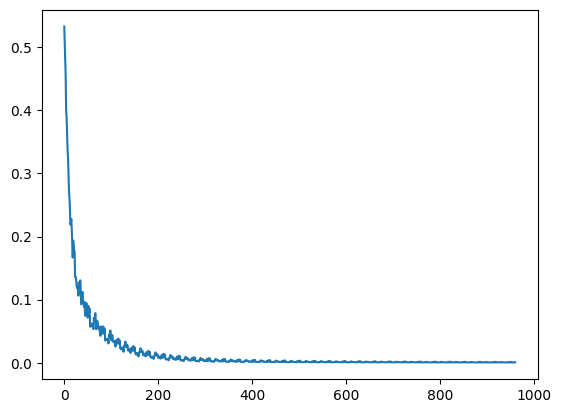

In [8]:
plt.plot(loss_vals)

# Eval

In [9]:
dataloader = DataLoader(
    DatasetUtils.drop_front(
        DatasetUtils.transform(
            dataset,
            lambda items: (items[0].to('cuda'),)
        ),
        2000
    ),
    batch_size=64
)
torch_model.to('cuda').eval()
graph_model.to('cuda').eval()

for data in dataloader:
    gt = torch_model(*data)
    pred = graph_model(*data)

    gt = gt.flatten(start_dim=1).float()
    pred = pred.flatten(start_dim=1).float()
    
    gt_max = gt.max(dim=1, keepdim=True)[0]
    gt_min = gt.min(dim=1, keepdim=True)[0]
    gt_mean = gt.mean(dim=1, keepdim=True)
    gt_range = gt_max - gt_min

    diff = torch.sqrt(torch.pow(gt - pred, 2))
    diff_max = diff.max(dim=1, keepdim=True)[0]
    diff_mean = diff.mean(dim=1, keepdim=True)
    
    items = torch.cat([gt_max, gt_min, gt_mean, gt_range, diff_max, diff_mean], dim=1)
    for item in items:
        print(item)
    break

tensor([0.1870, 0.0000, 0.0070, 0.1870, 0.5640, 0.0101], device='cuda:0',
       grad_fn=<UnbindBackward0>)
tensor([0.2515, 0.0000, 0.0092, 0.2515, 0.4576, 0.0115], device='cuda:0',
       grad_fn=<UnbindBackward0>)
tensor([0.4060, 0.0000, 0.0141, 0.4060, 0.6768, 0.0158], device='cuda:0',
       grad_fn=<UnbindBackward0>)
tensor([0.3460, 0.0000, 0.0121, 0.3460, 0.6236, 0.0126], device='cuda:0',
       grad_fn=<UnbindBackward0>)
tensor([0.3063, 0.0000, 0.0113, 0.3063, 0.3866, 0.0118], device='cuda:0',
       grad_fn=<UnbindBackward0>)
tensor([0.3713, 0.0000, 0.0120, 0.3713, 0.5235, 0.0128], device='cuda:0',
       grad_fn=<UnbindBackward0>)
tensor([0.3228, 0.0000, 0.0124, 0.3228, 0.7279, 0.0128], device='cuda:0',
       grad_fn=<UnbindBackward0>)
tensor([0.3470, 0.0000, 0.0060, 0.3470, 0.7871, 0.0066], device='cuda:0',
       grad_fn=<UnbindBackward0>)
tensor([0.1841, 0.0000, 0.0078, 0.1841, 0.4412, 0.0106], device='cuda:0',
       grad_fn=<UnbindBackward0>)
tensor([0.3040, 0.0000, 0.01

# Export

In [10]:
finalized_model = quantizer.finalize(graph_model)
finalized_model.to('cuda')

finalized_model.print_readable()

class GraphModule(torch.nn.Module):
    def forward(self, x):
         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace = ''.join(CapturedTraceback.extract().format())
        conv = self.conv(x);  x = None
        
         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace = ''.join(CapturedTraceback.extract().format())
        bn = self.bn(conv);  conv = None
        
         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace = ''.join(CapturedTraceback.extract().format())
        relu = self.relu(bn);  bn = None
        
         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace = ''.join(CapturedTraceback.extract().format())
        conv0 = self.conv0(relu);  relu = None
        
         # File: /opt/

"class GraphModule(torch.nn.Module):\n    def forward(self, x):\n         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace = ''.join(CapturedTraceback.extract().format())\n        conv = self.conv(x);  x = None\n        \n         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace = ''.join(CapturedTraceback.extract().format())\n        bn = self.bn(conv);  conv = None\n        \n         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace = ''.join(CapturedTraceback.extract().format())\n        relu = self.relu(bn);  bn = None\n        \n         # File: /opt/miniconda3/lib/python3.10/site-packages/torch/fx/proxy.py:219 in create_proxy, code: proxy.node.stack_trace = ''.join(CapturedTraceback.extract().format())\n        conv0 = self.conv0(relu);  relu = None\n        \n       

In [11]:
torch.onnx.export(
    finalized_model,
    tuple(next(iter(dataloader))),
    qmodel_path,
    input_names=['x'],
    output_names=['y'],
)
torch.onnx.export(
    torch_model,
    tuple(next(iter(dataloader))),
    model_path,
    input_names=['x'],
    output_names=['y'],
)